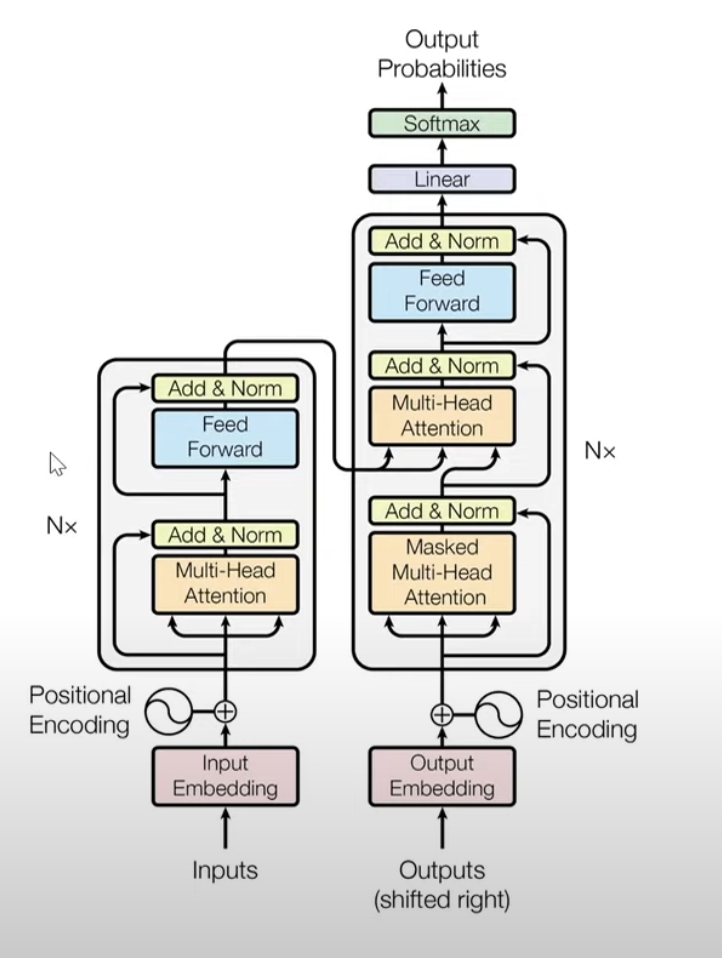

In [8]:
import torch
from torch import nn
import math

In [14]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        # Numerator and denominators for positional encoding 
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (Seq_Len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        # Apply sin and cos to even and odd positions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # (1, Seq_Len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)
        

In [15]:
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps
        # nn.Parameter makes the parameter learnable
        self.alpha = nn.Parameter(torch.ones(1)) # Multiplied
        self.bias = nn.Parameter(torch.zeros(1)) # Added

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # Bias is defined by default by the linear layer
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 and B1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 and B2

    def forward(self, x):
        # (Batch, Seq_Len, d_model) --> (Batch,Seq_Len, d_ff) --> (Batch, Seq_Len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [16]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        self.dropout = nn.Dropout(dropout)
        assert d_model % h == 0, "d_model is not divisible by h"
        
        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        
        # (Batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores
            
    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (Batch, Seq_Len, d_model) --> (Batch, Seq_Len, d_model)
        key = self.w_k(k) # (Batch, Seq_Len, d_model) --> (Batch, Seq_Len, d_model)
        value = self.w_v(v) # (Batch, Seq_Len, d_model) --> (Batch, Seq_Len, d_model)
        
        # (Batch, Seq_Len, d_model) --> (batch, seq_len, h, d_k) --> (Batch,h,seq_len,d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
        value = vale.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)
        
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.Dropout)
        
        # (batch, h, seq_len, d_k) --> (batch,seq_len,h,d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)
        
class ResidualConnection(nn.Module):

    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
    
class EncoderBlock(nn.Module):
    
    def __init__(
        self,
        self_attention_block: MultiHeadAttentionBlock,
        feed_forward_block: FeedForwardBlock,
        dropout: float
    ) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
        
    def forward(self, x, src_mask):
        x = self.residual_connections[0](
            x, lambda x: self.self_attention_block(x, x, x, src_mask)
        )
        x = self.residual_connections[1](x,self.feed_forward_block)
        return x
    
class Encoder(nn.Module):
    
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
        
        def forward(self, x, mask):
            for layer in self.layers:
                x = layer(x, mask)
            return self.norm(x)

class DecoderBlock(nn.Module):
    
    def __init__(
        self,
        self_attention_block: MultiHeadAttentionBlock,
        cross_attention_block: MultiHeadAttentionBlock,
        feed_forward_block: FeedForwardBlock,
        dropout: float
    ) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
        
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](
            x, lambda x: self.self_attention_block(x, x, x, tgt_mask)
        )
        x = self.residual_connections[0](
            x, lambda x: self.self_attention_block(x, encoder_output, encoder_output, src_mask)
        )
        x = self.residual_connections[2](x,self.feed_forward_block)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
        
        def forward(self, x, encoder_output, src_mask, tgt_mask):
            for layer in self.layers:
                x = layer(x, encoder_output, src_mask, tgt_mask)
            return self.norm(x)

class ProjectionLayer(nn.Module):
    
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)
        
        def forward (self, x):
            return torch.log_softmax(self.proj(x), dim = -1)
        
class Transformer(nn.Module):
    
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        src_embed: InputEmbeddings,
        tgt_embed: InputEmbeddings,
        src_pos: PositionalEncoding,
        tgt_pos: PositionalEncoding,
        projection_layer: ProjectionLayer
    ):
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer
        
    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        return self.projection_layer(x)
    
def build_transformer(
    src_vocab_size: int,
    tgt_vocab_size: int,
    src_seq_len: int,
    tgt_seq_len: int,
    d_model: int = 512,
    N: int = 6,
    h: int = 8,
    dropout: float = 0.1,
    d_ff: int = 2048
):
    # Create embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    
    # Create positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)
        
    # Create decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_atention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_atention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create encoder and decoder from blocks
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    
    # Create projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the full transformer
    transformer = Transformer(
        encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer
    )

    # Initialize Parameters
    for p in transformer.parameterseters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return transformer